![](brain.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plot

# Régression polynomiale (et autres combinaisons)

## Mise en situation

Je travaille sur un moteur de calculs : on traite un volume d'information (des lignes dans une base de données) pour en calculer certaines mesures.

Nous sommes face au problème suivant : quel pricing adpoter ? Plus exactement, en fonction du calcul demandé, quel serait le temps de calcul nécessaire à facturer à nos clients.

Mon rôle va être de modéliser une fonction qui estime le temps de calcul par rapport aux caractéristiques du calcul. J'ai déjà essayé une regression linéaire, sans succès :(

## Problème formel

Au lieu d'une combinaison linéaire, on va chercher une autre fonction, qui pourra 
* multiplier des variables entre elles
* diviser des variables entre elles
* appliquer des opérations comme la racine carrée, cubique, etc...

Et pour le coup, la méthode va être toute simple : on va enrichir notre jeu de données, tout simplement.

Là où on avait auparavant $x_1, x_2, ..., x_n$, on va ajouter de nouvelles mesures comme $x_1^2, x_2*x_3, \frac{x_4}{x_5}, \sqrt{x_6}, ...$

### Le piège de la dérivée

Pour rappel, on avait une fonction de coût $J$, qu'on dérivait pour obtenir une nouvelle formule, et on en faisait une équation à résoudre.

Si maintenant $\theta_1.x_1 + \theta_2.x_2$ est completé par $\theta_3.x_3$ avec $x_3 = \frac{x_1}{x_2}$, est-ce que ça ne fausserait pas notre calcul de dérivée ? Après tout, dériver une fraction c'est un peu différent ...

La réponse est non. Ce qu'il faut bien réaliser, c'est qu'on dérive la fonction $J$, non pas par rapport aux valeurs $x$, qui sont connues et constantes, mais par rapport aux valeurs de $\theta$, qui pour le coup sont toujours multipliées par des scalaires uniquement.

### Simulation rapide

Validons le concept, avec des petits exemples rapides

In [2]:

# Trouve le meilleur modèle par rapport à X et Y
def solve_model(X, Y) : 
    # On commence par ajouter une colonne x0 = 1
    Xtmp = np.concatenate([np.ones((X.shape[0],1)), X], axis = 1)
    # Puis on calcule theta
    return np.dot(np.dot(np.linalg.pinv(np.dot(Xtmp.T, Xtmp)), Xtmp.T), Y)


num_training_samples = 1000


# Données et fonction fictives : pour a,b,c donnés, on calcule souhaite calculer f(a,b,c) = 10 + 3a + 5ab + 6c^2
# on charche 1000 exemples a,b,c, et le résultat correspondant
X_demo = np.floor(np.random.rand(num_training_samples, 3)*100)
Y_demo = (10 + X_demo[:,0] * 3 + X_demo[:,0] * X_demo[:,1] * 5 + X_demo[:,2] ** 2 *6).reshape(num_training_samples, 1)

print("Exemple 1: a=%i, b=%i, c=%i, f(a,b,c)=%i" % (X_demo[0,0],X_demo[0,1],X_demo[0,2],Y_demo[0]))


# Résolution linéaire : donne un résultat complètement faux
theta_demo = solve_model(X_demo, Y_demo)
print("theta = " + str(theta_demo[:,0]))


Exemple 1: a=62, b=21, c=7, f(a,b,c)=7000
theta = [-21485.11519544    243.7114169     241.31541838    593.46549949]


In [3]:
# Ajout automatique de toutes les combinaisons de valeurs, au second degré
def add_2nd_degree_features(X):
    result = X
    for i in range(X.shape[1]):
        for j in range(i, X.shape[1]):
            result = np.concatenate([result, (X[:,i]*X[:,j]).reshape(X.shape[0],1)], axis=1)
    return result

# Regression linéaire sur des données à enrichir au second degré
def solve_model_2nd_degree(X, Y) :
    # On commence par enrichir notre jeu de données au second degré
    Xtmp = add_2nd_degree_features(X)
    # On y ajoute une colonne x0 = 1
    Xtmp = np.concatenate([np.ones((X.shape[0],1)), Xtmp], axis = 1)
    # Puis on calcule theta
    return np.dot(np.dot(np.linalg.pinv(np.dot(Xtmp.T, Xtmp)), Xtmp.T), Y)

# Nouvelle tentative
theta_demo = solve_model_2nd_degree(X_demo, Y_demo)
print("theta = " + str(np.round(theta_demo[:,0])))
print("Note the values, and map them to 1, a, b, c, a^2, ab, ac, b^2, bc, c^2.\nRemove zeros : 10 + 3a + 5ab + 6c^2 !!!")


# nouveau test, avec du bruit ( ratio : 1 +/- rate)
def generate_noise(matrix, rate):
    return matrix * (1-rate + np.random.rand(matrix.shape[0], 1) * rate * 2)

for noise_rate in [0.001, 0.01, 0.1]:
    X_noise = X_demo
    Y_noise = generate_noise(Y_demo, noise_rate)
    theta_noise = solve_model_2nd_degree(X_noise, Y_noise)
    print("Noise level: " + str(noise_rate) + ", theta = " + str(np.round(theta_noise[:,0])))


theta = [10.  3. -0. -0.  0.  5.  0.  0.  0.  6.]
Note the values, and map them to 1, a, b, c, a^2, ab, ac, b^2, bc, c^2.
Remove zeros : 10 + 3a + 5ab + 6c^2 !!!
Noise level: 0.001, theta = [ 9.  3. -0.  0.  0.  5.  0.  0. -0.  6.]
Noise level: 0.01, theta = [18.  2. -0. -1.  0.  5. -0.  0. -0.  6.]
Noise level: 0.1, theta = [-243.   -2.    7.   15.    0.    5.    0.    0.   -0.    6.]


### Analyse du resultat

Le résultat fonctionne. Par contre, le bruit a un impact beaucoup plus rapide sur le résultat : même une variation de +/- 1% va commencer à largement fausser le modèle !

Plus le modèle est complexe, et plus il dispose d'une grande latitude pour s'adapter à la demande. On en reparlera en même temps que la notion d'_overfit_. En deux images :

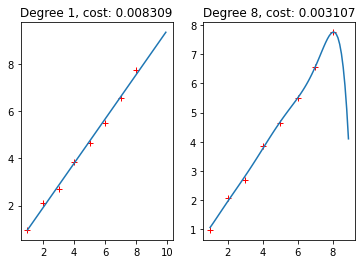

In [4]:
def evaluate(X, model):
    return np.dot(np.concatenate([np.ones((X.shape[0], 1)), X], axis=1), model)

def cost(X, model, Y):
    err = evaluate(X, model) - Y
    return np.sum(err**2) / 2 / X.shape[0]

# Generation de 8 points presque alignés
np.random.seed(1)
pts = 8
xpoints = (np.arange(pts)+1).reshape(pts, 1)
ypoints = xpoints * (0.9 + np.random.rand(pts, 1) * 0.2)

fig = plot.figure()

# Figure 1 : un modèle de degré 1, avec une faible erreur
fig.add_subplot(1, 2, 1)
# Affichage des points du dataset d'entrainement
p = plot.plot(xpoints, ypoints, "r+")
# calcul du modele
xdata = xpoints
theta = solve_model(xdata, ypoints)
# affichage de la courbe
x = np.arange(1,10, 0.1).reshape(-1, 1)
y = evaluate(x, theta)
p = plot.plot(x, y)
p = plot.title('Degree 1, cost: %f' % (cost(xdata, theta, ypoints)))

#figure 2 : un modèle de degré élevé, avec une erreur nulle
fig.add_subplot(1, 2, 2)
# plot points
p = plot.plot(xpoints, ypoints, "r+")
# calcul du modele
xdata = np.concatenate([xpoints.reshape(pts,1)**i for i in range(1, pts+1)], axis = 1)
theta = solve_model(xdata, ypoints)
# affichage de la courbe
x = np.arange(1,9, 0.1).reshape(-1, 1)
y = evaluate(np.concatenate([x**i for i in range(1, pts+1)], axis = 1), theta)
p = plot.plot(x, y)
p = plot.title('Degree 8, cost: %f' % (cost(xdata, theta, ypoints)))

Je cherche le modèle qui colle au mieux à ma donnée.

* La figure de gauche montre une ligne qui passe plus ou moins bien dans à travers tous les points. Le modèle colle plutôt bien.
* Celle de droite montre un modèle de degré beaucoup plus élevé. Il colle vraiment mieux à mes données... mais en terme de but recherché on n'y est pas du tout !!!

Dans notre simulation, si les données sont parfaites, on voit bien que le système arrivera à éliminer les termes inutiles ($\theta_i = 0$).

Mais les données sont rarement parfaites. Et pour compenser le moindre bruit dans les données, le système va se servir de tous ces termes inutiles pour ajuster au mieux son erreur.

En pratique, si on sait comment composer les différentes mesures, c'est préférable à une combinaison un peu bourrin de tous les termes sur plusieurs degrés.

De plus, toutes ces combinaisons font exploser le nombre de mesures. Pour $n$ mesures de degré 1, on en aura $\frac{n^2+3n}{2}$ au degré 2, $\frac{n^3+6n^2+11n}{6}$ au degré 3, etc... Et l'inversion de la matrice est elle-même une opération en $O(t^3)$ par rapport à la taille $t$ de la matrice, donc les calculs seront de plus en plus long si on monte en degré : pour un degré $d$, l'inversion de la matrice est en $O(n^{3d})$

## Retour à la mise en situation

### Chargement des données
On a un jeu de données : pour chaque calcul réalisé dans le passé on possède
* le nombre de lignes traitées (en milliers)
* un flag qui indique si la mesure M1 a été réalisée
* un flag qui indique si la mesure M2 a été réalisée
* un flag qui indique si la mesure M3 a été réalisée
* la durée du calcul, en secondes

In [5]:
data = np.load('data/d02_data.npy')
# chargement de X (toutes les colonnes sauf la dernière) et de Y (dernière colonne)
Xtrain = data[:,0:-1]
Ytrain = data[:,-1].reshape(-1,1)

print(str(Xtrain.shape[0]) + ' exemples chargés')

1000 exemples chargés


### Analyse graphique des données
On va regarder rapidement quels sont les impacts des différentes opérations m1, m2 et m3 par rapport au nombre de lignes, en ne visualisant que les cas où une seule opération est réalisée.

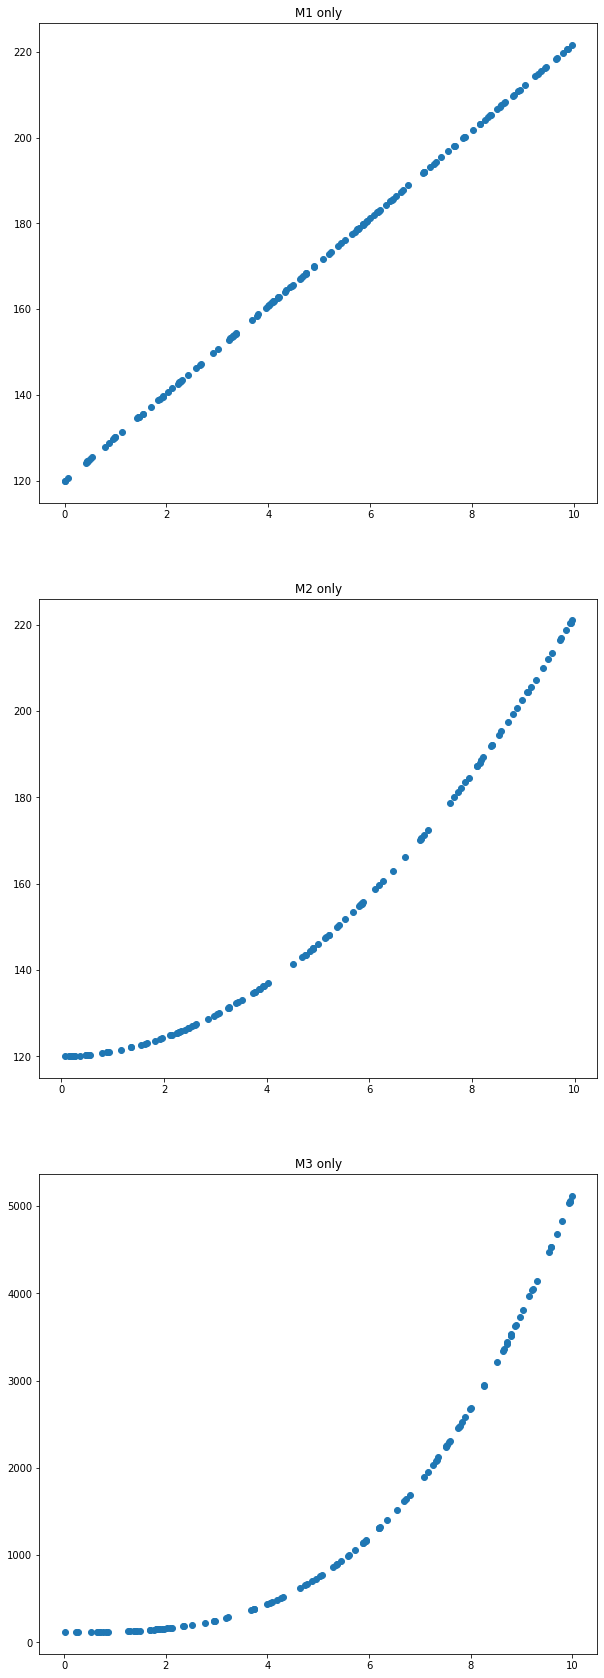

In [6]:
fig = plot.figure(figsize=(10,30))

# Selection des runs "M1 only"
indices = np.where(np.all([Xtrain[:,1] == 1, Xtrain[:,2] == 0, Xtrain[:,3] == 0],axis=0))
m1plot = fig.add_subplot(311)
m1plot.scatter(Xtrain[indices,0], Ytrain[indices])
t = plot.title('M1 only')

# Selection des runs "M2 only"
indices = np.where(np.all([Xtrain[:,1] == 0, Xtrain[:,2] == 1, Xtrain[:,3] == 0],axis=0))
m2plot = fig.add_subplot(312)
m2plot.scatter(Xtrain[indices,0], Ytrain[indices])
t = plot.title('M2 only')

# Selection des runs "M3 only"
indices = np.where(np.all([Xtrain[:,1] == 0, Xtrain[:,2] == 0, Xtrain[:,3] == 1],axis=0))
m3plot = fig.add_subplot(313)
m3plot.scatter(Xtrain[indices,0], Ytrain[indices])
t = plot.title('M3 only')

Bon, ok, encore une fois, ce n'est pas un vrai jeu de données, c'est pour l'exemple.

On remarque que l'impact du nombre de lignes sur M1 est plutôt linéaire, vaguement quadratique ou cubique pour les deux autres.

Maintenant, laissons le modèle determiner tout ça tout seul comme un grand. Mais comme expliqué, plutôt que de faire exploser les calculs, on va réfléchir aux mesures à ajouter.

Puisque m1, m2 et m3 sont des valeurs dans {0,1}, il n'y a pas grand intérêt à en calculer les puissances ($0^n = 0, 1^n = 1$ pour tout $n > 1$).

De même, je sais (connaissance business) que les mesures sont indépendantes, et donc il n'y a pas grand intérêt à multiplier les m1, m2, m3 entre eux.

Le reste peut être utile au calcul - même si on suspecte certains résultats grace aux graphiques ci-dessus. On va néanmoins entrainer différents modèles pour différentes valeurs du degré voulu.

For degree 1: cost is 104392.40016211515
For degree 2: cost is 2863.645769381509
For degree 3: cost is 6.33128733785399e-20
For degree 4: cost is 1.938346978301979e-17
For degree 5: cost is 5.93674375173922e-14
For degree 6: cost is 3.589363819271707e-11
For degree 7: cost is 0.1572163011171587
For degree 8: cost is 1371.6510512400876
For degree 9: cost is 2045.1664006684825
For degree 10: cost is 3042.865442071446


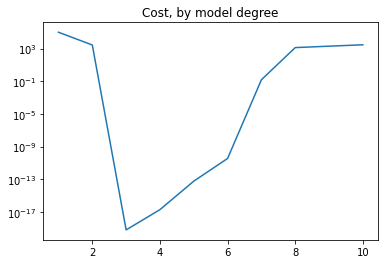

In [7]:
def enrich_data(X, degree) :
    m = X.shape[0]
    # On commence par calculer les puissances de la premiere colonne
    Xpow = np.concatenate([X[:,0].reshape(m, 1)**i for i in range(1,degree+1)], axis = 1)
    # On calcule ensuite les produits avec les m1, m2, m3
    Xm1 = Xpow**1 * X[:,1].reshape(m,1)
    Xm2 = Xpow * X[:,2].reshape(m,1)
    Xm3 = Xpow * X[:,3].reshape(m,1)
    # On construit une matrice avec tout ça
    Xtmp = np.concatenate([Xpow, Xm1, Xm2, Xm3], axis = 1)
    # On y ajoute une colonne x0 = 1
    Xtmp = np.concatenate([np.ones((m, 1)), Xtmp], axis = 1)
    return Xtmp
    
def solve_model_nth_degree(X, Y, degree) :
    # On enrichit les données
    Xenrich = enrich_data(X, degree)
    # Puis on calcule theta
    return np.dot(np.dot(np.linalg.pinv(np.dot(Xenrich.T, Xenrich)), Xenrich.T), Y)

# Calcul du coût
def cost(model, X, Y, degree) :
    err = np.dot(enrich_data(X, degree), model) - Y
    return np.dot(err.T, err)[0][0] / 2 / X.shape[0]

degrees = range(1, 11)
costs = np.zeros(10)

for deg in degrees : 
    theta = solve_model_nth_degree(Xtrain, Ytrain, deg)
    costs[deg-1] = cost(theta, Xtrain, Ytrain, deg)
    print(('For degree %i: cost is %s') % (deg, costs[deg-1]))

plot.yscale('log')
plot.title('Cost, by model degree')
p = plot.plot(degrees, costs)

On remarque que le modèle est vraiment optimal pour un degré 3. Regardons les valeurs de $\theta$ pour ce degré là

In [8]:
theta = solve_model_nth_degree(Xtrain, Ytrain, 3)
print(np.round(theta, 2).T)

[[120.    0.2  -0.    0.   10.    0.   -0.   -0.    1.   -0.   -0.    0.
    5. ]]


Analyse du résultat : 
* il y a un coût fixe de 120 secondes + 0.2 x le nombre de milliers de lignes (probablement le démarrage de la machine et le chargement des données)
* il y a ensuite un cout de 10 x milliers de lignes sur le calcul de la mesure 1
* il y a ensuite un cout quadratique en 1 par milliers de lignes sur le calcul de la mesure 2
* il y a enfin un cout cubique en 0.5 par milliers de lignes sur le calcul de la mesure 3

(ce qui correspond bien aux graphes qu'on avait tracé dans un premier temps !)

### Conclusion
La regression polynomiale permet d'obtenir un modèle quand on sort des combinaisons linéaires de valeurs.

En contrepartie, la complexité du modèle grandit de manière exponentielle, et le temps de calcul explose.